Splitting data into train/val/test sets...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best hyperparameters:
{'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.8}
Train set accuracy: 96.89%


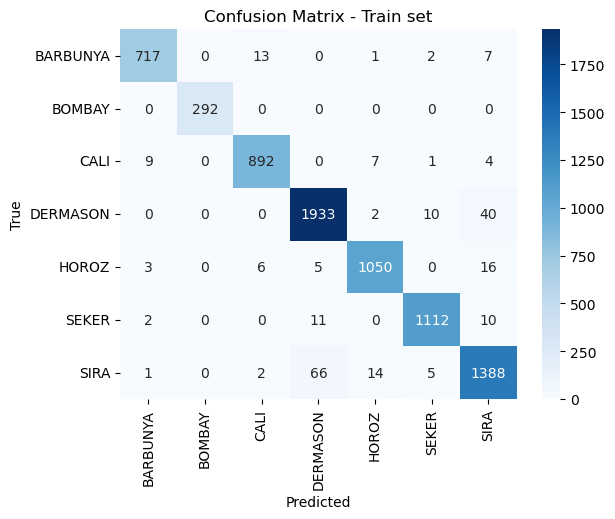

Classification report for train set:
              precision    recall  f1-score   support

    BARBUNYA       0.98      0.97      0.97       740
      BOMBAY       1.00      1.00      1.00       292
        CALI       0.98      0.98      0.98       913
    DERMASON       0.96      0.97      0.97      1985
       HOROZ       0.98      0.97      0.97      1080
       SEKER       0.98      0.98      0.98      1135
        SIRA       0.95      0.94      0.94      1476

    accuracy                           0.97      7621
   macro avg       0.97      0.97      0.97      7621
weighted avg       0.97      0.97      0.97      7621



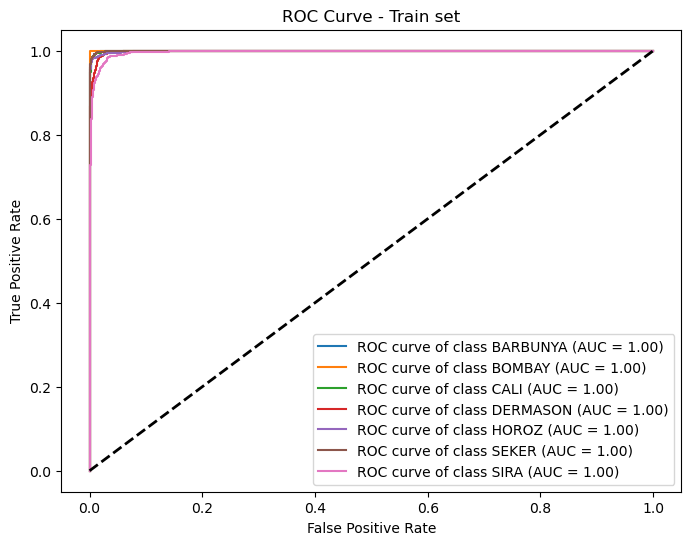

Average AUC (train set): 0.9990
Test set accuracy: 92.53%


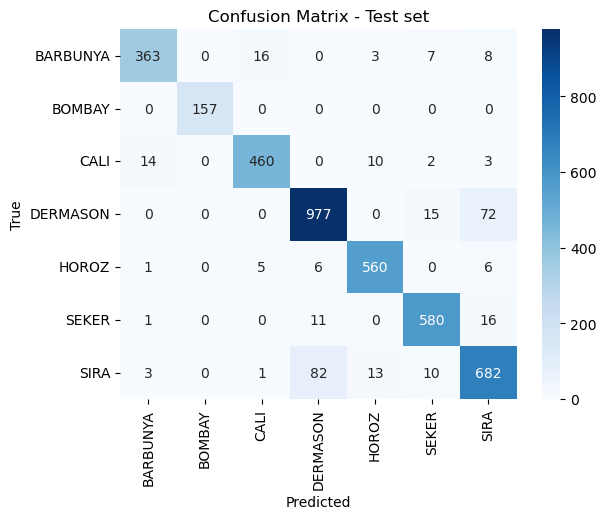

Classification report for test set:
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.91      0.93       397
      BOMBAY       1.00      1.00      1.00       157
        CALI       0.95      0.94      0.95       489
    DERMASON       0.91      0.92      0.91      1064
       HOROZ       0.96      0.97      0.96       578
       SEKER       0.94      0.95      0.95       608
        SIRA       0.87      0.86      0.86       791

    accuracy                           0.93      4084
   macro avg       0.94      0.94      0.94      4084
weighted avg       0.93      0.93      0.93      4084



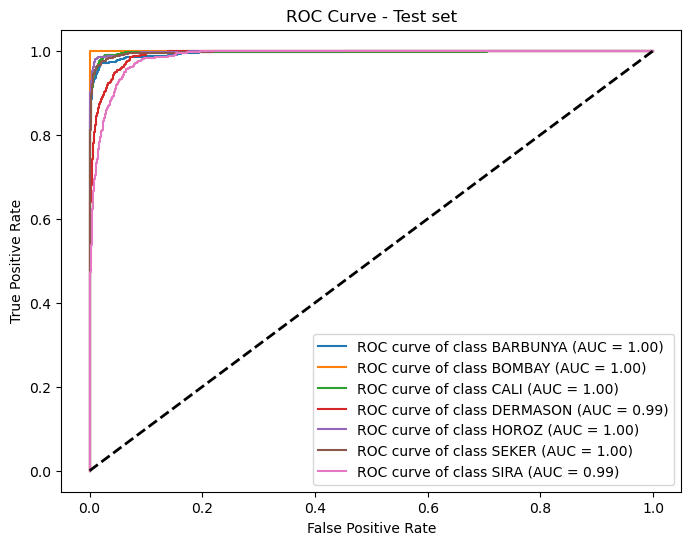

Average AUC (test set): 0.9951
Whole dataset accuracy: 95.02%


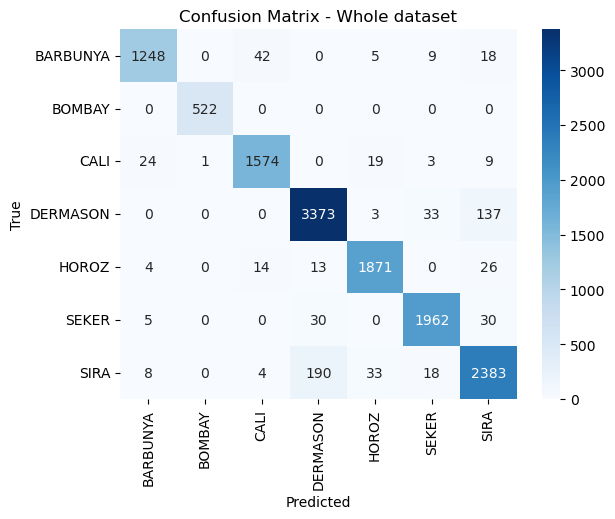

Classification report for whole dataset:
              precision    recall  f1-score   support

    BARBUNYA       0.97      0.94      0.96      1322
      BOMBAY       1.00      1.00      1.00       522
        CALI       0.96      0.97      0.96      1630
    DERMASON       0.94      0.95      0.94      3546
       HOROZ       0.97      0.97      0.97      1928
       SEKER       0.97      0.97      0.97      2027
        SIRA       0.92      0.90      0.91      2636

    accuracy                           0.95     13611
   macro avg       0.96      0.96      0.96     13611
weighted avg       0.95      0.95      0.95     13611



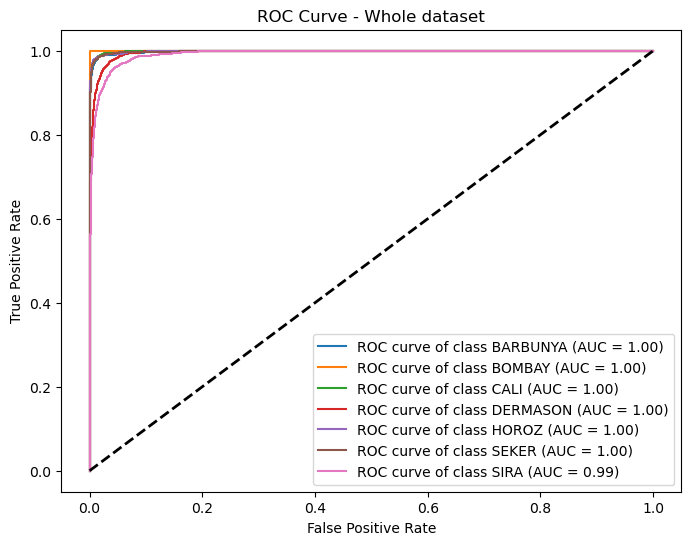

Average AUC (whole dataset): 0.9974


In [3]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

data = pd.read_csv("Dry_Bean_Dataset.csv")
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
classes = np.unique(y)
y_int = np.array([np.where(classes == label)[0][0] for label in y])

print("Splitting data into train/val/test sets...")
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y_int, test_size=0.3, random_state=42, stratify=y_int)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

# Define parameter grid for common hyperparameters (including regularization)
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'reg_lambda': [1, 2],  # L2 regularization (default is 1)
    'reg_alpha': [0, 1]    # L1 regularization (default is 0)
}

xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=len(classes),
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best hyperparameters:")
print(grid.best_params_)


import matplotlib.pyplot as plt

# Fit the best estimator on the full training set
final_model = grid.best_estimator_

# Prepare y_encoded for the whole dataset
y_encoded = y_int

# Define datasets and their names for iteration
datasets = [
    ("Train set", X_train, y_train),
    ("Test set", X_test, y_test),
    ("Whole dataset", X, y_encoded)
]

for name, X_set, y_set in datasets:
    y_pred = final_model.predict(X_set)
    accuracy = final_model.score(X_set, y_set) * 100
    print(f"{name} accuracy: {accuracy:.2f}%")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_set, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    print(f"Classification report for {name.lower()}:")
    print(classification_report(y_set, y_pred, target_names=classes))
    
    # Binarize the output for ROC curve (one-vs-rest)
    y_bin = label_binarize(y_set, classes=range(len(classes)))
    if hasattr(final_model, "predict_proba"):
        y_score = final_model.predict_proba(X_set)
    else:
        y_score = final_model.decision_function(X_set)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (AUC = {roc_auc[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()
    
    # Calculate and print average AUC
    average_auc = np.mean([roc_auc[i] for i in range(len(classes))])
    print(f'Average AUC ({name.lower()}): {average_auc:.4f}')

/var/folders/qk/zgyqcw1j2d7_d2zbzrqgtfmw0000gn/T/ipykernel_43494/3148275830.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.get_cmap('tab10', len(classes)))
/var/folders/qk/zgyqcw1j2d7_d2zbzrqgtfmw0000gn/T/ipykernel_43494/3148275830.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_int, cmap=plt.cm.get_cmap('tab10', len(classes)), edgecolor='k', s=20)


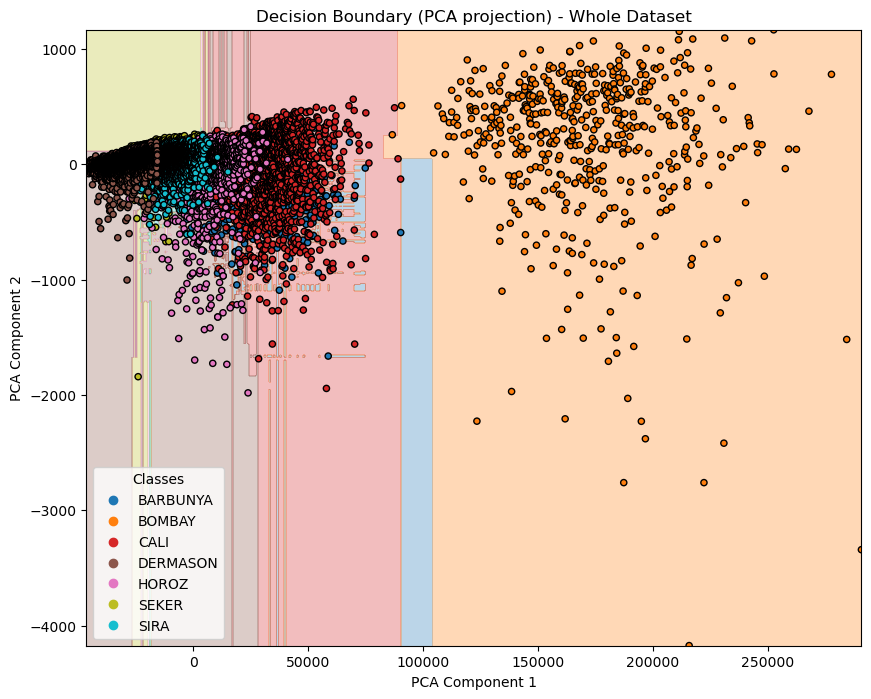

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
import numpy as np

# Reduce features to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Fit GradientBoostingClassifier on PCA-reduced data for visualization
model_vis = GradientBoostingClassifier(
    random_state=42,
    n_estimators=grid.best_params_["n_estimators"],
    learning_rate=grid.best_params_["learning_rate"],
    max_depth=grid.best_params_["max_depth"]
)
model_vis.fit(X_pca, y_int)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = model_vis.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.get_cmap('tab10', len(classes)))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_int, cmap=plt.cm.get_cmap('tab10', len(classes)), edgecolor='k', s=20)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary (PCA projection) - Whole Dataset')

# Add legend
handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, classes, title="Classes", loc="best")

plt.show()
